In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import svm
from sklearn.naive_bayes import GaussianNB

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import classification_report
import collections
from sklearn.metrics import classification_report


In [82]:
epi_data_df = pd.read_hdf('../data/processed/recipe_vectors.h5')

In [83]:
epi_data_df.shape

(48817, 4756)

## Helper functions

In [84]:
def countTags(sample_df):
    '''
    Takes in DF and get counts of tags using python Counter. 
    
    count: DataFrame
        DF to stores count. 
    indexNames: list
        Goes through DF and keeps index of count values less than 30. 
        We then drop columns in count DF.
    Return:
    ------
    count: Counter() value
    '''

    c = Counter()  
    sample_df["tags"].apply(lambda x: c.update(x))

    count = pd.DataFrame()
    count['tags_count'] = [c[i] for i in c]
    count['tag'] = [i for i in c]
    count = count.sort_values(by='tags_count',ascending=False)

    indexNames = count[ count['tags_count'] <= 30 ].index

    count.drop(indexNames , inplace=True)
    return count


In [85]:
def getallergyTags(count):
    '''
    Takes in count of tags and get any tags that ends with word 'Free'.
    
    Returns:
    Pandas DF with allergy tags and it's count.
    '''
    count['allergy_tags'] = count['tag'].str.endswith('Free')

    allergy_df = count[count['allergy_tags'] == True]
    return allergy_df

In [86]:
# Create column in sample_df for allergy tags
def addallergytoDF(allergy_df,df):
    '''
    Takes in DF with allergy tags and loops through it and add column of boolean in df.
    
    Returns:
    -------
    updated df with allergy columns added.
    '''
    for i in allergy_df.tag:
        df[i] = [i in tags for tags in df.tags]
    return df

In [87]:

def loadCuisineType():
    '''
    It read cuisinetype,usa_city and states file, cleans data read from it. 
    
    Returns:
    A list of usa_cuisine and non_usa_cuisine.
    '''
    cuisinetype = pd.read_csv('cuisinetype.txt',header=None)
    cuisinetype = cuisinetype.transpose()
    cuisinetype = np.array(cuisinetype[0])
    cuisinetype = [x.replace('\'','') for x in cuisinetype]
    cuisinetype = [x.replace('[','') for x in cuisinetype]
    cuisinetype = [x.replace(']','') for x in cuisinetype]
    cuisinetype = [x.lstrip() for x in cuisinetype]
    
    states = pd.read_csv('states.csv',header=None)
    states = states.transpose()
    states = np.array(states[0])
    states = [x.lstrip() for x in states]
    

    city = pd.read_csv('usa_city.csv',header=None)
    city = city.transpose()
    city = np.array(city[0])
    city = [x.replace('\'','') for x in city]
    city = [x.replace('[','') for x in city]
    city = [x.replace(']','') for x in city]
    city = [x.lstrip() for x in city]
    usa_cuisine =states+city
    
    non_usa_cuisine = []
    for i in cuisinetype:
        if i not in usa_cuisine:
            non_usa_cuisine.append(i)
    return usa_cuisine,non_usa_cuisine
    

In [88]:
def addCuisinetypesToDF(sample_df,usa_cuisine,non_usa_cuisine):
    '''
    It loops through sample_df and add boolean value based on whether tags contains usa cities 
    and states or non-usa or none of both.
    
    returns:
    --------
    update sample_df with usa_cuisine column
    '''
    tags_value=[]
    for tags in sample_df['tags']:
        if(set(tags).intersection(usa_cuisine)):
            tags_value.append(1)
            continue
        else:
            if(set(tags).intersection(non_usa_cuisine)):
                tags_value.append(0)
            else:
                tags_value.append(2)
    sample_df['usa_cuisine'] = tags_value
    return sample_df

In [89]:
def dropZeroColumns(sample_df):
    '''
    Takes in a DF and drops all the row with only zeros value. 
    
    Returns
    -------
    Reduced row DF
    '''
    sample_df = sample_df.loc[:, (sample_df != 0).any(axis=0)]
    return sample_df

In [90]:
def dropColumn(sample_df,col):
    '''
    Drops colums with infinite values. 
    
    Returns
    -------
    reduced column DF
    '''
    sample_df = sample_df[(sample_df != np.inf).all(axis=1)]
    sample_df = sample_df.drop(columns=col,axis=1)

    return sample_df

In [91]:

def getTrianData(sample_df,label_column):
    '''Seperate data and label to classify, 
    X are attribute columns used to classify, Y is the label
    first delete all infinity values in data. It also drop columns that are not needed.
    
    Returns
    -------
    
    data Df and label DF
    '''
    data = sample_df.drop(columns=label_column, axis=1)
    label = sample_df[label_column]
    return data,label


In [92]:
def addSeasontypesToDF(sample_df,season,label):
    '''
    Adds yearly seasons to sample_df
    
    season column value association:
    1 ==> spring, 2 ==> summer, 3 ==> fall, 4 ==> winter, 0 ==> NA
    Returns:
    update sample_df
    '''
    tags_value=[]
    for tags in sample_df['tags']:
        if(season[0] in set(tags)): 
            tags_value.append(1)
        elif(season[1] in set(tags)): 
            tags_value.append(2)
        elif(season[2] in set(tags)): 
            tags_value.append(3)
        elif(season[3] in set(tags)): 
            tags_value.append(4)
        else:
            tags_value.append(0) # for non-season food
    sample_df[label] = tags_value
    return sample_df

In [93]:
class SVCmodel(object):
    def __init__(self):
        pass
    def getSupport(self,model):
        '''Indices of support vectors'''
        return model.support_
    def getClassWeight(self,model):
        '''Support vectors'''
        return model.class_weight_
    def getNsupport(self,model):
        '''# of support vector for each class'''
        return model.n_support_
    def getsupportcoef(self,model):
        '''related to support vector in the decision function.'''
        return model.dual_coef_
    def getfeaturesweight(self,model):
        '''weight assigned to the features'''
        return model.coef_
    def getintercept(self,model):
        '''constants in decision function'''
        return model.intercept_
    def getfitstatus(self,model):
        '''0 if correctly fitted, 1 otherwise(will raise warning)'''
        return model.fit_status_
    def getclasses(self,model):
        '''The class label'''
        return model.classes_
    def getprobA(self,model):
        '''array type, shape = [n_class*(n_classes-1)/2]'''
        return model.probA_
    def getprobB(self,model):
        '''array type, shape = [n_class*(n_classes-1)/2].
        If probability=True, it corresponds to the parameters 
        learned in Platt scaling to produce probability estimates 
        from decision values. If probability=False, it’s an empty array. 
        Platt scaling uses the logistic function 
        1 / (1 + exp(decision_value * probA_ + probB_)) 
        where probA_ and probB_ are learned from the dataset 
        '''
        return model.probA_
    def getclassweight(self,model):
        '''multipliers of parameter C for each class.'''
        return model.class_weight_
    def getshapefit(self,model):
        return model.shape_fit_

## Data Preparation for Classification

In [94]:
%%time
# Cuisine Types: usa_cuisine ==> 1, non_usa_cuisine ==> 1, no_tags ==> 2
tags_count = countTags(epi_data_df)
usa_cuisine,non_usa_cuisine = loadCuisineType()
allergy_tags = getallergyTags(tags_count)
sample_df = epi_data_df.head(10000)
sample_df = addCuisinetypesToDF(sample_df,usa_cuisine,non_usa_cuisine)
cuisine_df = sample_df
sample_df = addallergytoDF(allergy_tags,sample_df)
sample_df = dropZeroColumns(sample_df)


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


CPU times: user 3.03 s, sys: 672 ms, total: 3.7 s
Wall time: 4.91 s


In [95]:
sample_df.head(2)

,Aleppo chili flake,Aleppo pepper,Amaretto,Amaretto liqueur,Amontillado sherry,Anaheim chili,Anaheim pepper,Angostura Bitters,Angostura bitter,Angostura or orange bitter,...,num_reviews,tags,title,usa_cuisine,Peanut Free,Soy Free,Tree Nut Free,Wheat/Gluten-Free,Dairy Free,Fat Free
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25.0,"[Cheese, Vegetable, No-Cook, Vegetarian, Quick...","""Adult"" Pimiento Cheese",1,False,False,False,False,False,False
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,"[Ginger, Dessert, Bake, Apple, Almond, Fall, R...","""An Apple a Day""",2,True,True,False,False,False,False


In [96]:
allergy = ['Peanut Free','Soy Free','Tree Nut Free','Wheat/Gluten-Free','Dairy Free','Fat Free']
sample_df[allergy] *= 1
sample_df.head(2)

/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,Aleppo chili flake,Aleppo pepper,Amaretto,Amaretto liqueur,Amontillado sherry,Anaheim chili,Anaheim pepper,Angostura Bitters,Angostura bitter,Angostura or orange bitter,...,num_reviews,tags,title,usa_cuisine,Peanut Free,Soy Free,Tree Nut Free,Wheat/Gluten-Free,Dairy Free,Fat Free
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25.0,"[Cheese, Vegetable, No-Cook, Vegetarian, Quick...","""Adult"" Pimiento Cheese",1,0,0,0,0,0,0
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,"[Ginger, Dessert, Bake, Apple, Almond, Fall, R...","""An Apple a Day""",2,1,1,0,0,0,0


In [97]:
sample_df.shape

(10000, 3119)

In [100]:
s = Counter()
tags_list = []
count = 0
for tags in sample_df['tags']:
    if('Peanut' in tags):
#         print(tags)
        count +=1
        for i in tags:
            tags_list.append(i)

print("Tags list Containing Peanut Ingredient is ",count)
s.update(tags_list)
s.most_common(10)

Tags list Containing Peanut Ingredient is  84


[('Peanut', 84),
 ('Tree Nut Free', 47),
 ('Vegetarian', 44),
 ('Soy Free', 42),
 ('Bon Appétit', 40),
 ('Kosher', 39),
 ('Dessert', 37),
 ('Pescatarian', 35),
 ('Kid-Friendly', 28),
 ('Gourmet', 27)]

In [101]:
tags_count.head()

,tags_count,tag,allergy_tags
19,16565,Peanut Free,True
20,16131,Soy Free,True
17,15512,Bon Appétit,False
34,14049,Tree Nut Free,True
3,13552,Vegetarian,False


### Deletes Not used columns for Classification

In [102]:
drop_column = ['avg_rating','best_rating','prepare_again_rating','num_reviews','usa_cuisine','tags','title']
label_column = ['Peanut Free','Soy Free','Tree Nut Free','Wheat/Gluten-Free','Dairy Free','Fat Free']

# copy1 = sample_df
# copy2 = sample_df
# usa_tag_df = deleterows(copy1,'usa_cuisine',2,'',True)
# no_cuisine_tag_df = deleterows(copy2,'usa_cuisine',1,0,False)


In [103]:
sample_df.head(2)

,Aleppo chili flake,Aleppo pepper,Amaretto,Amaretto liqueur,Amontillado sherry,Anaheim chili,Anaheim pepper,Angostura Bitters,Angostura bitter,Angostura or orange bitter,...,num_reviews,tags,title,usa_cuisine,Peanut Free,Soy Free,Tree Nut Free,Wheat/Gluten-Free,Dairy Free,Fat Free
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25.0,"[Cheese, Vegetable, No-Cook, Vegetarian, Quick...","""Adult"" Pimiento Cheese",1,0,0,0,0,0,0
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,"[Ginger, Dessert, Bake, Apple, Almond, Fall, R...","""An Apple a Day""",2,1,1,0,0,0,0


In [104]:
sample_df = dropColumn(sample_df,drop_column)

In [105]:
sample_df.head(2)

,Aleppo chili flake,Aleppo pepper,Amaretto,Amaretto liqueur,Amontillado sherry,Anaheim chili,Anaheim pepper,Angostura Bitters,Angostura bitter,Angostura or orange bitter,...,ziti pasta,zucchini,zucchini flower,zucchini squash,Peanut Free,Soy Free,Tree Nut Free,Wheat/Gluten-Free,Dairy Free,Fat Free
http://www.epicurious.com/recipes/food/views/-adult-pimiento-cheese-100852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0,0,0,0
http://www.epicurious.com/recipes/food/views/-an-apple-a-day-51133430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,1,0,0,0,0


In [106]:
training_data,testing_data = train_test_split(sample_df,test_size= 0.2)
train_data,train_label = getTrianData(training_data,label_column)
test_data,test_label = getTrianData(testing_data,label_column)

In [107]:
# train_data,train_label = getTrianData(training_data,label_column)
# test_data,test_label = getTrianData(test_data,label_column)

In [108]:
train_data.head(2)

,Aleppo chili flake,Aleppo pepper,Amaretto,Amaretto liqueur,Amontillado sherry,Anaheim chili,Anaheim pepper,Angostura Bitters,Angostura bitter,Angostura or orange bitter,...,za'atar,zest lemon,zest lime,zest navel orange,zest orange,ziti,ziti pasta,zucchini,zucchini flower,zucchini squash
http://www.epicurious.com/recipes/food/views/bell-pepper-relish-2680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
http://www.epicurious.com/recipes/food/views/bulgur-pilaf-with-dried-apricots-240947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [109]:
train_data.shape

(8000, 3106)

In [110]:
test_data.head(5)

,Aleppo chili flake,Aleppo pepper,Amaretto,Amaretto liqueur,Amontillado sherry,Anaheim chili,Anaheim pepper,Angostura Bitters,Angostura bitter,Angostura or orange bitter,...,za'atar,zest lemon,zest lime,zest navel orange,zest orange,ziti,ziti pasta,zucchini,zucchini flower,zucchini squash
http://www.epicurious.com/recipes/food/views/chocolate-glaze-51157030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
http://www.epicurious.com/recipes/food/views/brassicas-bowl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
http://www.epicurious.com/recipes/food/views/barramundi-fillets-with-roasted-sweet-potatoes-and-brussels-sprout-chips-355232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
http://www.epicurious.com/recipes/food/views/corn-pancakes-102079,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
http://www.epicurious.com/recipes/food/views/andalusian-pork-rolls-301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Support Vector Classifier

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

Below website gives good explaination on reading result from SVC

https://www.datacamp.com/community/tutorials/svm-classification-scikit-learn-python

### Fit model without weights

Referenced example from this link: https://www.geeksforgeeks.org/classifying-data-using-support-vector-machinessvms-in-python/

In [29]:
train_size = 1000

In [30]:
%%time
svc = svm.SVC(kernel='linear')
svc.fit(train_data.iloc[:train_size],train_label['Peanut Free'].iloc[:train_size]) #train
p = svc.predict(test_data) #predict

CPU times: user 2min 52s, sys: 1 s, total: 2min 53s
Wall time: 3min 7s


In [31]:
c = Counter()
c.update(test_label['Peanut Free'])
print("SVC-No Weight")
print("Actual label count ",c)
c = Counter()
c.update(p)
print("prediction label count ",c)

SVC-No Weight
Actual label count  Counter({0: 1059, 1: 941})
prediction label count  Counter({0: 1024, 1: 976})


In [32]:
print("\n\n          SVC Classificatin Report-No Weight\n\n")
print(classification_report(test_label['Peanut Free'],p))



          SVC Classificatin Report-No Weight


              precision    recall  f1-score   support

           0       0.55      0.53      0.54      1059
           1       0.49      0.51      0.50       941

    accuracy                           0.52      2000
   macro avg       0.52      0.52      0.52      2000
weighted avg       0.52      0.52      0.52      2000



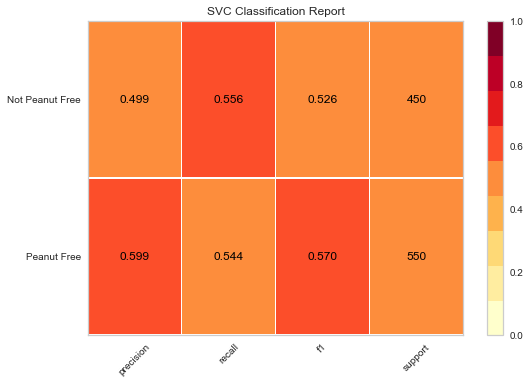

CPU times: user 4.3 s, sys: 146 ms, total: 4.45 s
Wall time: 4.89 s


In [33]:
%%time
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(svc, classes=['Peanut Free','Not Peanut Free'], support=True)
visualizer.fit(train_data.iloc[:train_size], train_label['Peanut Free'].iloc[:train_size])        # Fit the visualizer and the model
visualizer.score(test_data.iloc[:train_size], test_label['Peanut Free'].iloc[:train_size])        # Evaluate the model on the test data
plt.title("SVC Classification Report-Peanut")
plt.savefig('plots/no_weight_peanut_svc_result.png')
visualizer.show() 

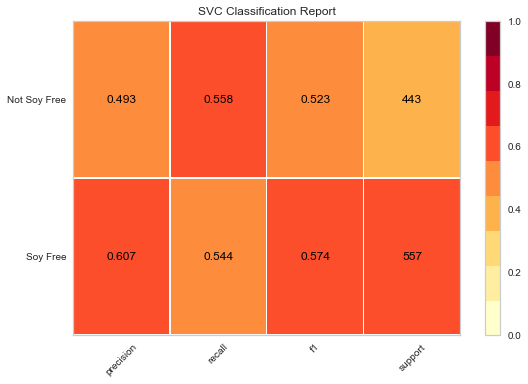

CPU times: user 4.34 s, sys: 44.2 ms, total: 4.39 s
Wall time: 4.86 s


In [34]:
%%time
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(svc, classes=['Soy Free','Not Soy Free'], support=True)
visualizer.fit(train_data.iloc[:train_size], train_label['Soy Free'].iloc[:train_size])        # Fit the visualizer and the model
visualizer.score(test_data.iloc[:train_size], test_label['Soy Free'].iloc[:train_size])        # Evaluate the model on the test data
plt.title("SVC Classification Report-Soy")
plt.savefig('plots/no_weight_soy_svc_result.png')
visualizer.show() 

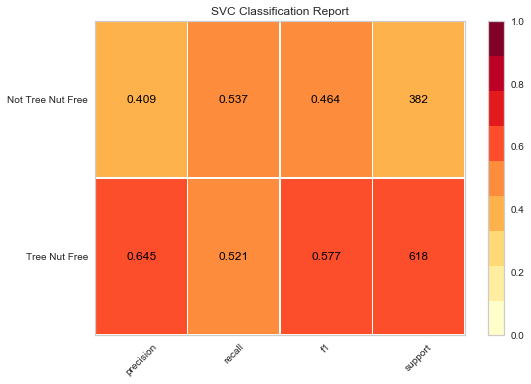

CPU times: user 4.29 s, sys: 37.2 ms, total: 4.32 s
Wall time: 4.78 s


In [35]:
%%time
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(svc, classes=['Tree Nut Free','Not Tree Nut Free'], support=True)
visualizer.fit(train_data.iloc[:train_size], train_label['Tree Nut Free'].iloc[:train_size])        # Fit the visualizer and the model
visualizer.score(test_data.iloc[:train_size], test_label['Tree Nut Free'].iloc[:train_size])        # Evaluate the model on the test data
plt.title("SVC Classification Report-Tree Nut")
plt.savefig('plots/no_weight_treenut_svc_result.png')
visualizer.show() 

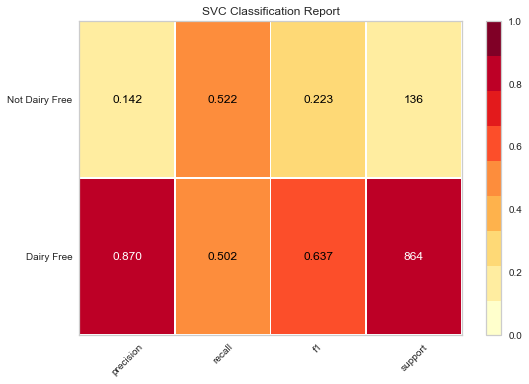

CPU times: user 4.28 s, sys: 51.7 ms, total: 4.33 s
Wall time: 4.85 s


In [36]:
%%time
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(svc, classes=['Dairy Free','Not Dairy Free'], support=True)
visualizer.fit(train_data.iloc[:train_size], train_label['Dairy Free'].iloc[:train_size])        # Fit the visualizer and the model
visualizer.score(test_data.iloc[:train_size], test_label['Dairy Free'].iloc[:train_size])        # Evaluate the model on the test data
plt.title("SVC Classification Report-Dairy")
plt.savefig('plots/no_weight_dairy_svc_result.png')
visualizer.show() 

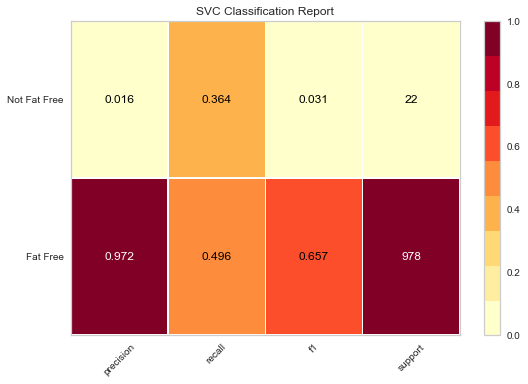

CPU times: user 4.19 s, sys: 22.5 ms, total: 4.21 s
Wall time: 4.27 s


In [37]:
%%time
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(svc, classes=['Fat Free','Not Fat Free'], support=True)
visualizer.fit(train_data.iloc[:train_size], train_label['Fat Free'].iloc[:train_size])        # Fit the visualizer and the model
visualizer.score(test_data.iloc[:train_size], test_label['Fat Free'].iloc[:train_size])        # Evaluate the model on the test data
plt.title("SVC Classification Report-Fat")
plt.savefig('plots/no_weight_fat_svc_result.png')
visualizer.show() 

### Fit model with weights

Before we fit models with weight, we also wanted to find best parameters to improve performance. We used below commentted cell to loop through and store parameters and accuracy values. In there, we also sampled test and trian data again to get better result. It takes long time to run and complete. Therefore, we only did for few loops.

In [38]:
# %%time 
# best_nu = -1
# best_acc = -1
# best_degree = -1
# best_kernel = ''
# w = -1

# nu = []
# degree = []
# kernel = []
# acc_list = []
# for n in range(1,9):
#     nu_v = 0.1*n
#     w += 1
#     for k in ["linear", "poly", "rbf", "sigmoid"]:
#         for d in range(1,10):
#             avg_acc = 0
#             for i in range(10):
#                 training_data,test_data = train_test_split(sample_df,test_size= 0.2)
#                 train_data,train_label = getTrianData(training_data,label_column[0])
#                 test_data,test_label = getTrianData(test_data,label_column[0])
# #                 new_labels = np.asarray(train_label.values)
# #                 c = Counter()
# #                 c.update(new_labels)
# #                       #degree_v = 0.05*i
#                 w_svc = svm.NuSVC(nu = nu_v, kernel=k, gamma='auto',degree = d, class_weight={0:weight_ratio[0][0]},probability=True)
# #                 print("fitting model")
#                 w_svc.fit(train_data.iloc[:train_size], train_label.iloc[:train_size])#,sample_weight=cal_w) 
# #                 print("predicting now")
#                 y_pred = w_svc.predict(test_data)
#                 acc = 0
#                 for idx, val in enumerate(y_pred):
#                     #print(test_label)
#                     if val == test_label.values[idx]:
#                         acc += 1
#                 acc /= len(y_pred)
#                 avg_acc += acc
#                 print('{}: {}'.format(i,acc))
#             avg_acc /= 4
#             print('Kernel: {}, nu: {}, Degree: {} , Avg Acc: {} '.format(k,nu_v, d, avg_acc))
#             if avg_acc > best_acc:
#                 degree.append(d)
#                 kernel.append(k)
#                 nu.append(nu_v)
#                 acc_list.append(avg_acc)
#             if k != "poly":
#                 break

                

Below are the values we got after running above code.

In [39]:
degree = [1, 1, 2, 3, 4, 1, 1, 1, 1, 2, 3, 4, 1, 1, 1, 1, 2]
degree
kernel =['linear', 'poly', 'poly', 'poly', 'poly', 'rbf', 'sigmoid',
        'linear', 'poly', 'poly', 'poly', 'poly', 'rbf', 'sigmoid',
        'linear', 'poly', 'poly']
nu = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.1 , 0.1 , 0.1 , 0.1 ,
        0.1 , 0.1 , 0.1 , 0.15, 0.15, 0.15]
acc_list = [0.90653153, 0.90728228, 0.61473974, 0.56681682, 0.53440941,
        0.75525526, 0.50287788, 0.90840841, 0.90578078, 0.60047548,
        0.56881882, 0.53553554, 0.75575576, 0.5289039 , 0.90515516,
        0.90302803, 0.5701952 ]
# degree,kernel,nu,acc_list

In [40]:
svc_df = pd.DataFrame()
svc_df['Degree'] = degree
svc_df['Kernel'] = kernel
svc_df['Nu'] = nu
svc_df['Accuracy'] = acc_list
svc_df

,Degree,Kernel,Nu,Accuracy
0,1,linear,0.05,0.906532
1,1,poly,0.05,0.907282
2,2,poly,0.05,0.614740
3,3,poly,0.05,0.566817
4,4,poly,0.05,0.534409
5,1,rbf,0.05,0.755255
6,1,sigmoid,0.05,0.502878
7,1,linear,0.10,0.908408
8,1,poly,0.10,0.905781
9,2,poly,0.10,0.600475


In [41]:
import mplcursors

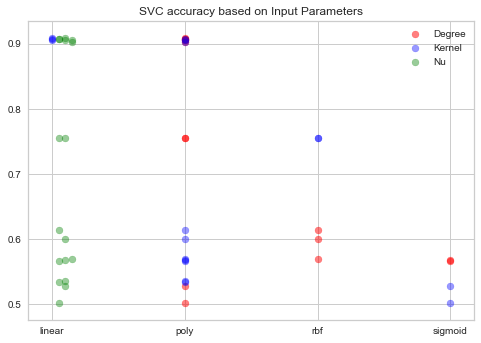

In [42]:
plt.scatter(degree,acc_list,alpha=0.5,color='red',label='Degree')
plt.scatter(kernel,acc_list,alpha=0.4,color='blue',label='Kernel')
plt.scatter(nu,acc_list,alpha=0.4,color='green',label='Nu')
plt.legend()
mplcursors.cursor(hover=True)
plt.title("SVC accuracy based on Input Parameters")
plt.savefig("plots/svc_accury_by_parameters.png")
plt.show()

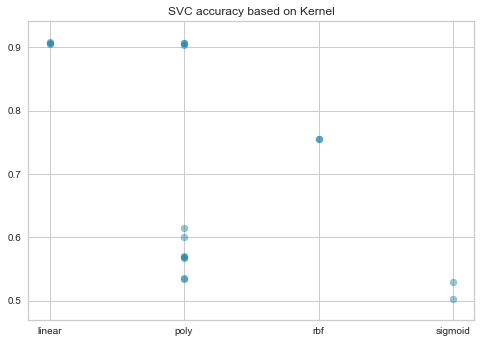

In [43]:
plt.scatter(kernel,acc_list,alpha=0.4)
plt.title("SVC accuracy based on Kernel")
plt.savefig("plots/accuracy_by_kernel.png")
plt.show()

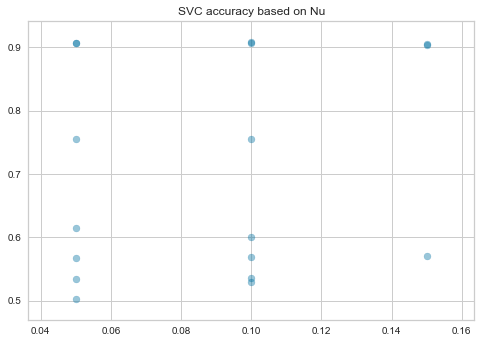

In [44]:
plt.scatter(nu,acc_list,alpha=0.4)
plt.title("SVC accuracy based on Nu")
plt.savefig("plots/accuracy_by_nu.png")
plt.show()

#### Calculate Weight

we calculate weight ration for True/False by counting True/False and divide by total. Then we store the ratio as tuple, (False_label_ration, True_label_ration), in weight_ration list. 

In [45]:
weight_ratio = []
for i in train_label:
    max_v = [int(train_label[i][train_label[i] == 0].value_counts())/len(train_label),int(train_label[i][train_label[i] == 1].value_counts())/len(train_label)]
    weight_ratio.append(max_v)
weight_ratio

[[0.511625, 0.488375],
 [0.522, 0.478],
 [0.604125, 0.395875],
 [0.737625, 0.262375],
 [0.847625, 0.152375],
 [0.981, 0.019]]

Weight Ratio for 'Peanut Free' tags.

In [46]:
weight_ratio[0][0]

0.511625

## Single Class Classification

In [47]:
train_size

1000

In [48]:
%%time
w_svc = svm.NuSVC(nu = 0.1, gamma='auto',class_weight={0:weight_ratio[0][0]},kernel='linear')
w_svc.fit(train_data.iloc[:train_size], train_label['Peanut Free'][:train_size])
p = svc.predict(test_data) #predict

CPU times: user 2min, sys: 825 ms, total: 2min 1s
Wall time: 2min 12s


In [49]:
%%time
p = w_svc.predict(test_data)

CPU times: user 4.26 s, sys: 60.8 ms, total: 4.32 s
Wall time: 4.97 s


In [50]:
print("\n\n          SVC Classificatin Report-With Weight\n\n")

print(classification_report(test_label['Peanut Free'],p))



          SVC Classificatin Report-With Weight


              precision    recall  f1-score   support

           0       0.56      0.55      0.55      1059
           1       0.50      0.52      0.51       941

    accuracy                           0.53      2000
   macro avg       0.53      0.53      0.53      2000
weighted avg       0.53      0.53      0.53      2000



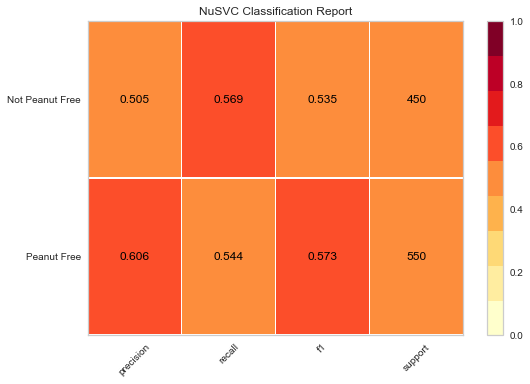

CPU times: user 4.4 s, sys: 65.8 ms, total: 4.46 s
Wall time: 4.87 s


In [51]:
%%time
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(w_svc, classes=['Peanut Free','Not Peanut Free'], support=True)
visualizer.fit(train_data.iloc[:train_size], train_label['Peanut Free'].iloc[:train_size])        # Fit the visualizer and the model
visualizer.score(test_data.iloc[:train_size], test_label['Peanut Free'].iloc[:train_size])        # Evaluate the model on the test data
visualizer.show() 

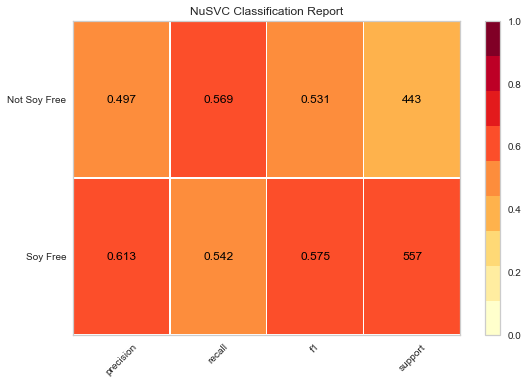

CPU times: user 4.33 s, sys: 41.7 ms, total: 4.37 s
Wall time: 4.49 s


In [52]:
%%time
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(w_svc, classes=['Soy Free','Not Soy Free'], support=True)
visualizer.fit(train_data.iloc[:train_size], train_label['Soy Free'].iloc[:train_size])        # Fit the visualizer and the model
visualizer.score(test_data.iloc[:train_size], test_label['Soy Free'].iloc[:train_size])        # Evaluate the model on the test data
visualizer.show() 

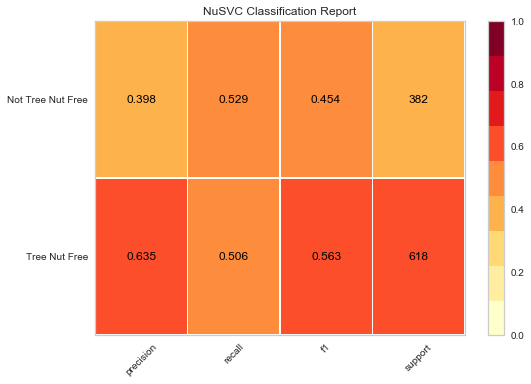

CPU times: user 4.36 s, sys: 48.9 ms, total: 4.41 s
Wall time: 4.86 s


In [53]:
%%time
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(w_svc, classes=['Tree Nut Free','Not Tree Nut Free'], support=True)
visualizer.fit(train_data.iloc[:train_size], train_label['Tree Nut Free'].iloc[:train_size])        # Fit the visualizer and the model
visualizer.score(test_data.iloc[:train_size], test_label['Tree Nut Free'].iloc[:train_size])        # Evaluate the model on the test data
visualizer.show() 

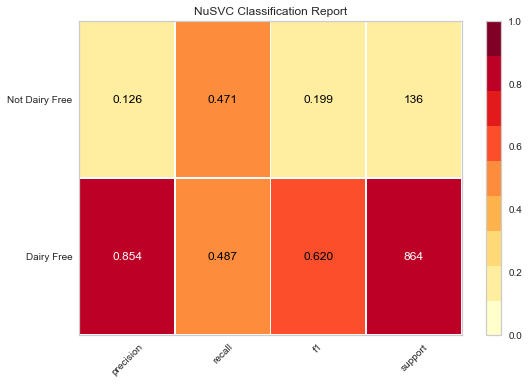

CPU times: user 4.32 s, sys: 37.7 ms, total: 4.36 s
Wall time: 4.47 s


In [54]:
%%time
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(w_svc, classes=['Dairy Free','Not Dairy Free'], support=True)
visualizer.fit(train_data.iloc[:train_size], train_label['Dairy Free'].iloc[:train_size])        # Fit the visualizer and the model
visualizer.score(test_data.iloc[:train_size], test_label['Dairy Free'].iloc[:train_size])        # Evaluate the model on the test data
visualizer.show() 

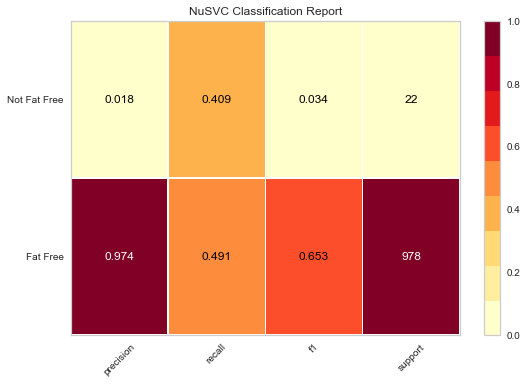

CPU times: user 4.34 s, sys: 29.8 ms, total: 4.37 s
Wall time: 4.43 s


In [55]:
%%time
from yellowbrick.classifier import ClassificationReport
visualizer = ClassificationReport(w_svc, classes=['Fat Free','Not Fat Free'], support=True)
visualizer.fit(train_data.iloc[:train_size], train_label['Fat Free'].iloc[:train_size])        # Fit the visualizer and the model
visualizer.score(test_data.iloc[:train_size], test_label['Fat Free'].iloc[:train_size])        # Evaluate the model on the test data
visualizer.show() 

In [56]:
c = Counter()
c.update(test_label['Peanut Free'])
print("SVC - With Weight")
print("actual label count:",c)
c = Counter()
c.update(p)
print("prediction label count:",c)

SVC - With Weight
actual label count: Counter({0: 1059, 1: 941})
prediction label count: Counter({0: 1036, 1: 964})


In [57]:
c = Counter()
c.update(p)
print("prediction label count ",c)

prediction label count  Counter({0: 1036, 1: 964})


## Naive Bayes Classifier

In [58]:
# # create a guassian classifier
bayes_model = GaussianNB()
bayes_model.fit(train_data,train_label['Peanut Free'])
print(bayes_model.epsilon_)

0.00017176756739109485


In [59]:
p = bayes_model.predict(test_data)

In [60]:
print("\n\n          Naive Bayes Classificatin Report\n\n")

print(classification_report(test_label['Peanut Free'],p))



          Naive Bayes Classificatin Report


              precision    recall  f1-score   support

           0       0.65      0.32      0.43      1059
           1       0.51      0.81      0.63       941

    accuracy                           0.55      2000
   macro avg       0.58      0.56      0.53      2000
weighted avg       0.59      0.55      0.52      2000



In [61]:
c = Counter()
c.update(test_label['Peanut Free'])
print("Naive Bayes Classifier")
print("actual label count:",c)
c = Counter()
c.update(bayes_model.predict(test_data))
print("prediction label count:",c)

Naive Bayes Classifier
actual label count: Counter({0: 1059, 1: 941})
prediction label count: Counter({1: 1489, 0: 511})


In [62]:
c = Counter()
c.update(bayes_model.predict(test_data))
print("prediction label count ",c)

prediction label count  Counter({1: 1489, 0: 511})


## Future Work

Having visual representation of data and it's result is very important to interprete. We wanted to try what they have done below. But due to time constraint, we could not do it. This would be something we would love to do in the future or if we had more time. 

#### Example from Sklearn Website

https://scikit-learn.org/stable/auto_examples/svm/plot_weighted_samples.html

Automatically created module for IPython interactive environment
[1.04855297 1.42001794 1.70627019 1.9507754  0.50965218 0.4380743
 1.25279536 0.77749036 1.61389785 3.1911042  0.89546656 0.3869025
 0.51080514 1.18063218 0.02818223 2.14165935 0.33258611 1.51235949
 3.17161047 1.81370583]


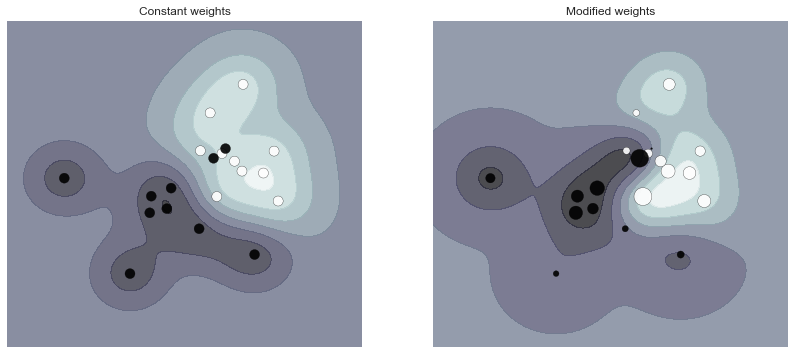

In [63]:
print(__doc__)

def plot_decision_function(classifier, sample_weight, axis, title):
    # plot the decision function
    xx, yy = np.meshgrid(np.linspace(-4, 5, 500), np.linspace(-4, 5, 500))

    Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # plot the line, the points, and the nearest vectors to the plane
    axis.contourf(xx, yy, Z, alpha=0.75, cmap=plt.cm.bone)
    axis.scatter(X[:, 0], X[:, 1], c=y, s=100 * sample_weight, alpha=0.9,
                 cmap=plt.cm.bone, edgecolors='black')

    axis.axis('off')
    axis.set_title(title)


# we create 20 points
np.random.seed(0)
X = np.r_[np.random.randn(10, 2) + [1, 1], np.random.randn(10, 2)]
y = [1] * 10 + [-1] * 10
sample_weight_last_ten = abs(np.random.randn(len(X)))
sample_weight_constant = np.ones(len(X))
# and bigger weights to some outliers
sample_weight_last_ten[15:] *= 5
sample_weight_last_ten[9] *= 15

# for reference, first fit without sample weights
print(sample_weight_last_ten)
# fit the model
clf_weights = svm.SVC(gamma=1)
clf_weights.fit(X, y, sample_weight=sample_weight_last_ten)

clf_no_weights = svm.SVC(gamma=1)
clf_no_weights.fit(X, y)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_decision_function(clf_no_weights, sample_weight_constant, axes[0],
                       "Constant weights")
plot_decision_function(clf_weights, sample_weight_last_ten, axes[1],
                       "Modified weights")

plt.show()

Below example is from this website: https://scikit-learn.org/0.18/auto_examples/svm/plot_iris.html

Automatically created module for IPython interactive environment


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


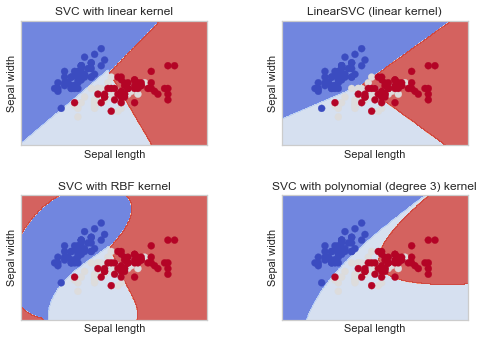

In [64]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets

# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features. We could
                      # avoid this ugly slicing by using a two-dim dataset
y = iris.target

h = .02  # step size in the mesh

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
svc = svm.SVC(kernel='linear', C=C).fit(X, y)
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X, y)
poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X, y)
lin_svc = svm.LinearSVC(C=C).fit(X, y)

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel']


for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
    plt.xlabel('Sepal length')
    plt.ylabel('Sepal width')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()